# AnTeDe Lab 13: Named Entity Recognition with a bidirectional LSTM and Conditional Random Fields

## Session goal
In this session we'll implement a Named Entity Recognition system using a bidirectional LSTM and Conditional Random Fields based on:
*   Z. Huang et al., **Bidirectional LSTM-CRF Models for Sequence Tagging**, Arxiv preprint, 2015
*   G. Lample et al., **Neural Architectures for Named Entity Recognition**, NAACL 2016




In [1]:
# Install extra-dependencies
#! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite
%tensorflow_version 1.x
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TensorFlow 1.x selected.


Using TensorFlow backend.


Here we set the hyperparameters.

In [2]:
BATCH_SIZE = 512  
EPOCHS = 100 
MAX_LEN = 80  
EMBEDDING = 300 
LSTM_UNITS = 150

Here we process the CONLL 2003 dataset.

In [3]:
!pip install wget
import wget

validation_url='https://www.dropbox.com/s/ed6l16yvsi2ngjl/eng.testa?dl=1'
test_url='https://www.dropbox.com/s/i14erxmgcx2bdxc/eng.testb?dl=1'
training_url='https://www.dropbox.com/s/0lmclaa237w20le/eng.train?dl=1'

import os
if 'CONLL-2003' not in os.listdir():
    os.mkdir('CONLL-2003')

    wget.download(validation_url, 'CONLL-2003') 
    wget.download(test_url, 'CONLL-2003') 
    wget.download(training_url, 'CONLL-2003') 

from nltk.corpus.reader import ConllCorpusReader

train_sents = list(ConllCorpusReader('CONLL-2003', 'eng.train', ['words', 'pos', 'ignore', 'chunk']).iob_sents())
test_sents = list(ConllCorpusReader('CONLL-2003', 'eng.testb', ['words', 'pos', 'ignore', 'chunk']).iob_sents())
validation_sents = list(ConllCorpusReader('CONLL-2003', 'eng.testa', ['words', 'pos', 'ignore', 'chunk']).iob_sents())

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=f7b122c083a00dcd56e4ccb8d74f1e41707aa60e7d8c9e97ddf3902729f8f468
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In the following cell we analyze our dataset so we know what we are dealing with.

In [4]:
count = 0
max_count = 0

tags = []
words = []
sentences = train_sents + test_sents + validation_sents

lendict = {}
count = 0

for sent in sentences:
    if count > 0:
        try:
            lendict[count] = lendict[count] + 1
        except:
            lendict[count] = 1
    count = 0
    
    for entry in sent:
        count = count+1
        if count > max_count:
            max_count = count
            
        words.append(entry[0])
        tags.append(entry[2])

tags = list(set(tags))

n_words = len(words)
print("Number of words in the dataset: ", n_words)
print("Max. word count per sentence: ", max_count)

print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

lendict

Number of words in the dataset:  301418
Max. word count per sentence:  124
Tags: ['I-ORG', 'I-MISC', 'B-LOC', 'O', 'I-PER', 'B-MISC', 'I-LOC', 'B-ORG']
Number of Labels:  8


{1: 227,
 2: 1671,
 3: 846,
 4: 1155,
 5: 1069,
 6: 934,
 7: 1542,
 8: 1607,
 9: 1247,
 10: 753,
 11: 591,
 12: 470,
 13: 465,
 14: 410,
 15: 378,
 16: 330,
 17: 331,
 18: 304,
 19: 297,
 20: 335,
 21: 350,
 22: 321,
 23: 308,
 24: 309,
 25: 321,
 26: 306,
 27: 285,
 28: 309,
 29: 324,
 30: 292,
 31: 302,
 32: 263,
 33: 257,
 34: 224,
 35: 196,
 36: 193,
 37: 169,
 38: 151,
 39: 148,
 40: 114,
 41: 103,
 42: 93,
 43: 81,
 44: 71,
 45: 62,
 46: 38,
 47: 28,
 48: 25,
 49: 22,
 50: 21,
 51: 13,
 52: 16,
 53: 9,
 54: 6,
 55: 12,
 56: 6,
 57: 3,
 58: 2,
 59: 4,
 60: 3,
 62: 3,
 64: 1,
 66: 1,
 67: 1,
 69: 1,
 71: 1,
 72: 1,
 75: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 83: 1,
 91: 1,
 93: 1,
 105: 1,
 109: 1,
 113: 1,
 124: 1}

Now we need to prepare our dataset. In particular, we need to pad our word/tag sequences so we can feed them to the LSTM in a batch.

In [5]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

idx2word = {i: w for w, i in word2idx.items()}

In [6]:
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

idx2tag = {i: w for w, i in tag2idx.items()}

In [7]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def prepare_word_sequences(sentences):
    X = [[word2idx[w[0]] for w in s] for s in sentences]
    X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=0)
    return X

def prepare_tag_sequences(sentences):    
    y = [[tag2idx[w[2]] for w in s] for s in sentences]
    y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=0)
    y = np.array([to_categorical(i, num_classes=n_tags+1) for i in y])
    return y

X_training = prepare_word_sequences(train_sents)
X_test = prepare_word_sequences(test_sents)
X_validation = prepare_word_sequences(validation_sents)
y_training = prepare_tag_sequences(train_sents)
y_test = prepare_tag_sequences(test_sents)
y_validation = prepare_tag_sequences(validation_sents)

Now we download the Glove embeddings so we can use them in the first layer of our network.

In [8]:
import os, numpy as np

if 'glove.6B.100d.txt' not in os.listdir():
    target_url = 'https://www.dropbox.com/s/rft33p9cuynhp83/glove.6B.100d.txt?dl=1'
    wget.download(target_url, '.')  

if 'glove.6B.300d.txt' not in os.listdir():  
    target_url = 'https://www.dropbox.com/s/gibuiv6mb7xgakp/glove.6B.300d.txt?dl=1'
    wget.download(target_url, '.')   

!ls

CONLL-2003  glove.6B.100d.txt  glove.6B.300d.txt  sample_data


In [9]:
if EMBEDDING == 100:
    glove_file = 'glove.6B.100d.txt'
else:
    glove_file = 'glove.6B.300d.txt'

f = open(glove_file)
embeddings_index = {}

for line in f:    
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
embedding_matrix = np.zeros((n_words+2, EMBEDDING))
for i, word in enumerate(words):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

And now we finally get to define our model. 

In [11]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-nodqsnyl
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-nodqsnyl
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp37-none-any.whl size=101065 sha256=e7969e4cd3983428c5e5bed25babc52aafd078cb5a77a464838f5dc8fc657c01
  Stored in directory: /tmp/pip-ephem-wheel-cache-73_b2fsx/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [12]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Masking
from keras_contrib.layers import CRF

# Model definition
inputs = Input(shape=(MAX_LEN,))
model = Masking(mask_value=0, input_shape=(MAX_LEN,))(inputs)
model = Embedding(input_dim=n_words + 2, # n_words + 2 (PAD & UNK)
                  output_dim=EMBEDDING, 
                  weights=[embedding_matrix], 
                  trainable=True, 
                  input_length=MAX_LEN)(model)  
model = Bidirectional(LSTM(units=LSTM_UNITS, 
                           return_sequences=True, 
                           recurrent_dropout=0.1, 
                           dropout=0.5))(model)  
model = Dropout(rate=0.5)(model)
#model = TimeDistributed(Dense(LSTM_UNITS, activation="relu"))(model)  # some practitioners also add this layer

crf = CRF(n_tags+1)  # CRF layer, n_tags+1 (PAD)
out = crf(model)  # output

model = Model(inputs, out)
model.compile(optimizer="nadam", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.7/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
masking_1 (Masking)          (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           90426000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 300)           541200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 300)           0         
_________________________________________________________________
crf_1 (CRF)                  (None, 80, 9)             2808      
Total params: 90,970,008
Traina

Now we evaluate our model. Every *CHECK_INTERVAL* epochs, we run it on the test set to see what's really happening.

In [13]:
from keras.callbacks import Callback

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from itertools import chain


ground_truth = np.argmax(y_test, -1)


def IOB_classification_report(y_true, y_pred):
    lb = LabelBinarizer()
    y_true_combined = lb.fit_transform(list(chain.from_iterable(y_true)))
    y_pred_combined = lb.transform(list(chain.from_iterable(y_pred)))
        
    tagset = set(lb.classes_) - {'O', 'PAD'}
    tagset = sorted(tagset, key=lambda tag: tag.split('-', 1)[::-1])
    class_indices = {cls: idx for idx, cls in enumerate(lb.classes_)}
    
    return classification_report(
        y_true_combined,
        y_pred_combined,
        labels = [class_indices[cls] for cls in tagset],
        target_names = tagset,
    )

class TestCallback(Callback):
    def __init__(self, test_data, check_accuracy, check_performance):
        self.test_data = test_data
        self.accuracy = check_accuracy
        self.run = check_performance

    def on_epoch_end(self, epoch=0, logs={}):
        x, y = self.test_data
        if self.accuracy:
            loss, acc = model.evaluate(x, y, verbose=1)
            print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
        
        if self.run or epoch % CHECK_INTERVAL == 0:
            pred_cat = model.predict(x, verbose=1)
            pred = np.argmax(pred_cat, axis=-1)

            pred_tag = [[idx2tag[i] for i in row] for row in pred]
            ground_truth_tag = [[idx2tag[i] for i in row] for row in ground_truth] 

            print(IOB_classification_report(ground_truth_tag, pred_tag))

In [14]:
check_accuracy = False
check_performance = False
CHECK_INTERVAL = 3

history = model.fit(X_training, y_training, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=(X_validation, y_validation), 
                    shuffle=True, 
                    verbose=1,
                    callbacks=[TestCallback((X_test, y_test), check_accuracy, check_performance)])


Train on 14987 samples, validate on 3466 samples
Epoch 1/100
3684/3684 [==============================] - 10s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         6
       I-LOC       0.00      0.00      0.00      1914
      B-MISC       0.00      0.00      0.00         9
      I-MISC       0.00      0.00      0.00       909
       B-ORG       0.00      0.00      0.00         5
       I-ORG       0.00      0.00      0.00      2490
       I-PER       0.61      0.03      0.05      2763

   micro avg       0.56      0.01      0.02      8096
   macro avg       0.09      0.00      0.01      8096
weighted avg       0.21      0.01      0.02      8096
 samples avg       0.00      0.00      0.00      8096

Epoch 2/100
14987/14987 [==============================] - 12s 822us/step - loss: 0.1029 - crf_viterbi_accuracy: 0.9702 - val_loss: 0.0860 - val_crf_viterbi_accuracy: 0.9718
Epoch 3/100
14987/14987 [==============================] - 12s 822us/step - loss: 0.0652 - crf_viterbi_accuracy: 0.9791 - val_loss: 0.0535 - val_crf_viterbi_accuracy: 0.9826
E

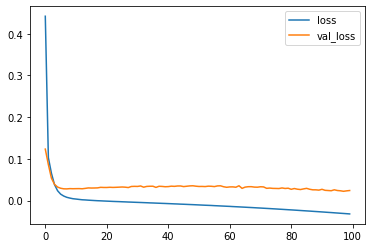

In [23]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

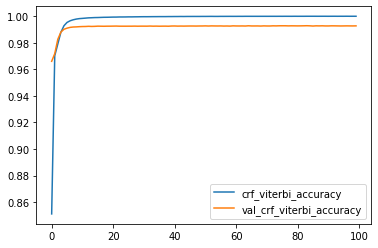

In [24]:
plt.plot(history.history['crf_viterbi_accuracy'], label='crf_viterbi_accuracy')
plt.plot(history.history['val_crf_viterbi_accuracy'], label='val_crf_viterbi_accuracy')
plt.legend()
plt.show()

In [15]:
pred_cat = model.predict(X_test, verbose=1)
pred = np.argmax(pred_cat, axis=-1)

pred_tag = [[idx2tag[i] for i in row] for row in pred]
ground_truth_tag = [[idx2tag[i] for i in row] for row in ground_truth] 

print (IOB_classification_report(ground_truth_tag, pred_tag))

3684/3684 [==============================] - 10s 3ms/step
              precision    recall  f1-score   support

       B-LOC       0.00      0.00      0.00         6
       I-LOC       0.88      0.82      0.85      1914
      B-MISC       0.17      0.11      0.13         9
      I-MISC       0.79      0.72      0.76       909
       B-ORG       0.00      0.00      0.00         5
       I-ORG       0.85      0.72      0.78      2490
       I-PER       0.91      0.67      0.77      2763

   micro avg       0.87      0.72      0.79      8096
   macro avg       0.51      0.43      0.47      8096
weighted avg       0.87      0.72      0.79      8096
 samples avg       0.02      0.02      0.02      8096



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
